# BE Machine Learning - Modélisation Prédictive de la Performance d'une rame de Métro à partir d'un jeu de données

Thomas DOS et Lisa ESCARON

## Présentation du jeu de données

Depuis une rame de métro en service, des mesures de pression, de température, de courant moteur et des volets d'admission d'air ont été relevées sur l'unité de production d'air (APU) d'un compresseur. 

Le jeu de données a été collecté pour permettre le développement de modèles de maintenance prédictive, de détection d’anomalies et de prédiction de la durée de vie restante (RUL) des compresseurs, en utilisant des méthodes d’apprentissage profond et d’apprentissage automatique. Il consiste en des séries temporelles multivariées issues de plusieurs capteurs analogiques et numériques installés sur le compresseur de la rame. Les données couvrent la période de février à août 2020 et comprennent 15 signaux (pressions, courant moteur, température de l’huile, signaux électriques des volets d’admission d’air, etc.). La surveillance et la journalisation des événements industriels (comportement temporel et événements de panne) proviennent des enregistrements générés par les capteurs. Les données ont été consignées à 1 Hz par un dispositif embarqué. 

Les données sont disponibles sous le format d'un fichier csv. On commence par les télécharger et visualiser les informations générales : 

In [1]:
import pandas as pd
df = pd.read_csv("MetroPT3(AirCompressor).csv")

In [2]:
df.tail(10)

,Unnamed: 0,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
1516938,15169380,2020-09-01 03:58:21,-0.012,8.990,8.974,-0.022,8.992,60.075,0.0450,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1516939,15169390,2020-09-01 03:58:31,-0.012,8.974,8.960,-0.022,8.976,60.150,0.0450,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1516940,15169400,2020-09-01 03:58:40,-0.012,8.960,8.946,-0.020,8.962,59.950,0.0450,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1516941,15169410,2020-09-01 03:58:50,-0.012,8.946,8.932,-0.022,8.948,59.850,0.0450,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1516942,15169420,2020-09-01 03:59:00,-0.012,8.934,8.920,-0.022,8.934,59.775,0.0450,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1516943,15169430,2020-09-01 03:59:10,-0.014,8.918,8.906,-0.022,8.918,59.675,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1516944,15169440,2020-09-01 03:59:20,-0.014,8.904,8.888,-0.020,8.904,59.600,0.0450,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1516945,15169450,2020-09-01 03:59:30,-0.014,8.890,8.876,-0.022,8.892,59.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1516946,15169460,2020-09-01 03:59:40,-0.012,8.876,8.864,-0.022,8.878,59.550,0.0450,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1516947,15169470,2020-09-01 03:59:50,-0.014,8.860,8.848,-0.022,8.864,59.475,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


In [3]:
print(df.shape)

(1516948, 17)


Le jeu de données se compose de 1516948 points collectés sur une période de 6 mois. Il est décrit par 15 variables provenant de 7 capteurs analogiques et 8 capteurs numériques.

On a 15 signaux mais 17 colonnes car on a deux colonnes supplémentaires : timestamp (date et heure de la mesure) et la première qui donne le nombre de minutes écoulées depuis le début de la collecte des données (10 minutes entre chaque mesure).

# Modèle de détection d'anomalies

Ce jeu de données a été créé pour la pédiction de pannes et l'explications d'anomalies entre autre. Sur la période de février à août 2020, on a un historiques des erreurs et pannes du compresseur. 

<table>
  <tr>
    <th>Erreur</th><th>Début</th><th>Fin</th><th>Type d'erreur</th>
  </tr>
  <tr>
    <td>#1</td><td>4/18/2020 0:00</td><td>4/18/2020 23:59</td><td>Air Leak</td>
  </tr>
  <tr>
    <td>#2</td><td>5/29/2020 23:30</td><td>5/30/2020 6:00</td><td>Air Leak</td>
  </tr>
  <tr>
    <td>#3</td><td>6/5/2020 10:00</td><td>6/7/2020 14:30</td><td>Air Leak</td>
  </tr>
  <tr>
    <td>#4</td><td>7/15/2020 14:30</td><td>7/15/2020 19:00</td><td>Air Leak</td>
  </tr>
</table>

On veut visualiser ces périodes d'erreurs sur les signaux du compresseur. On pourra ainsi visualiser une première fois les anomalies sur les signaux et comprendre ce qu'il se passe avant d'entraîner un modèle de détection d'anomalies.

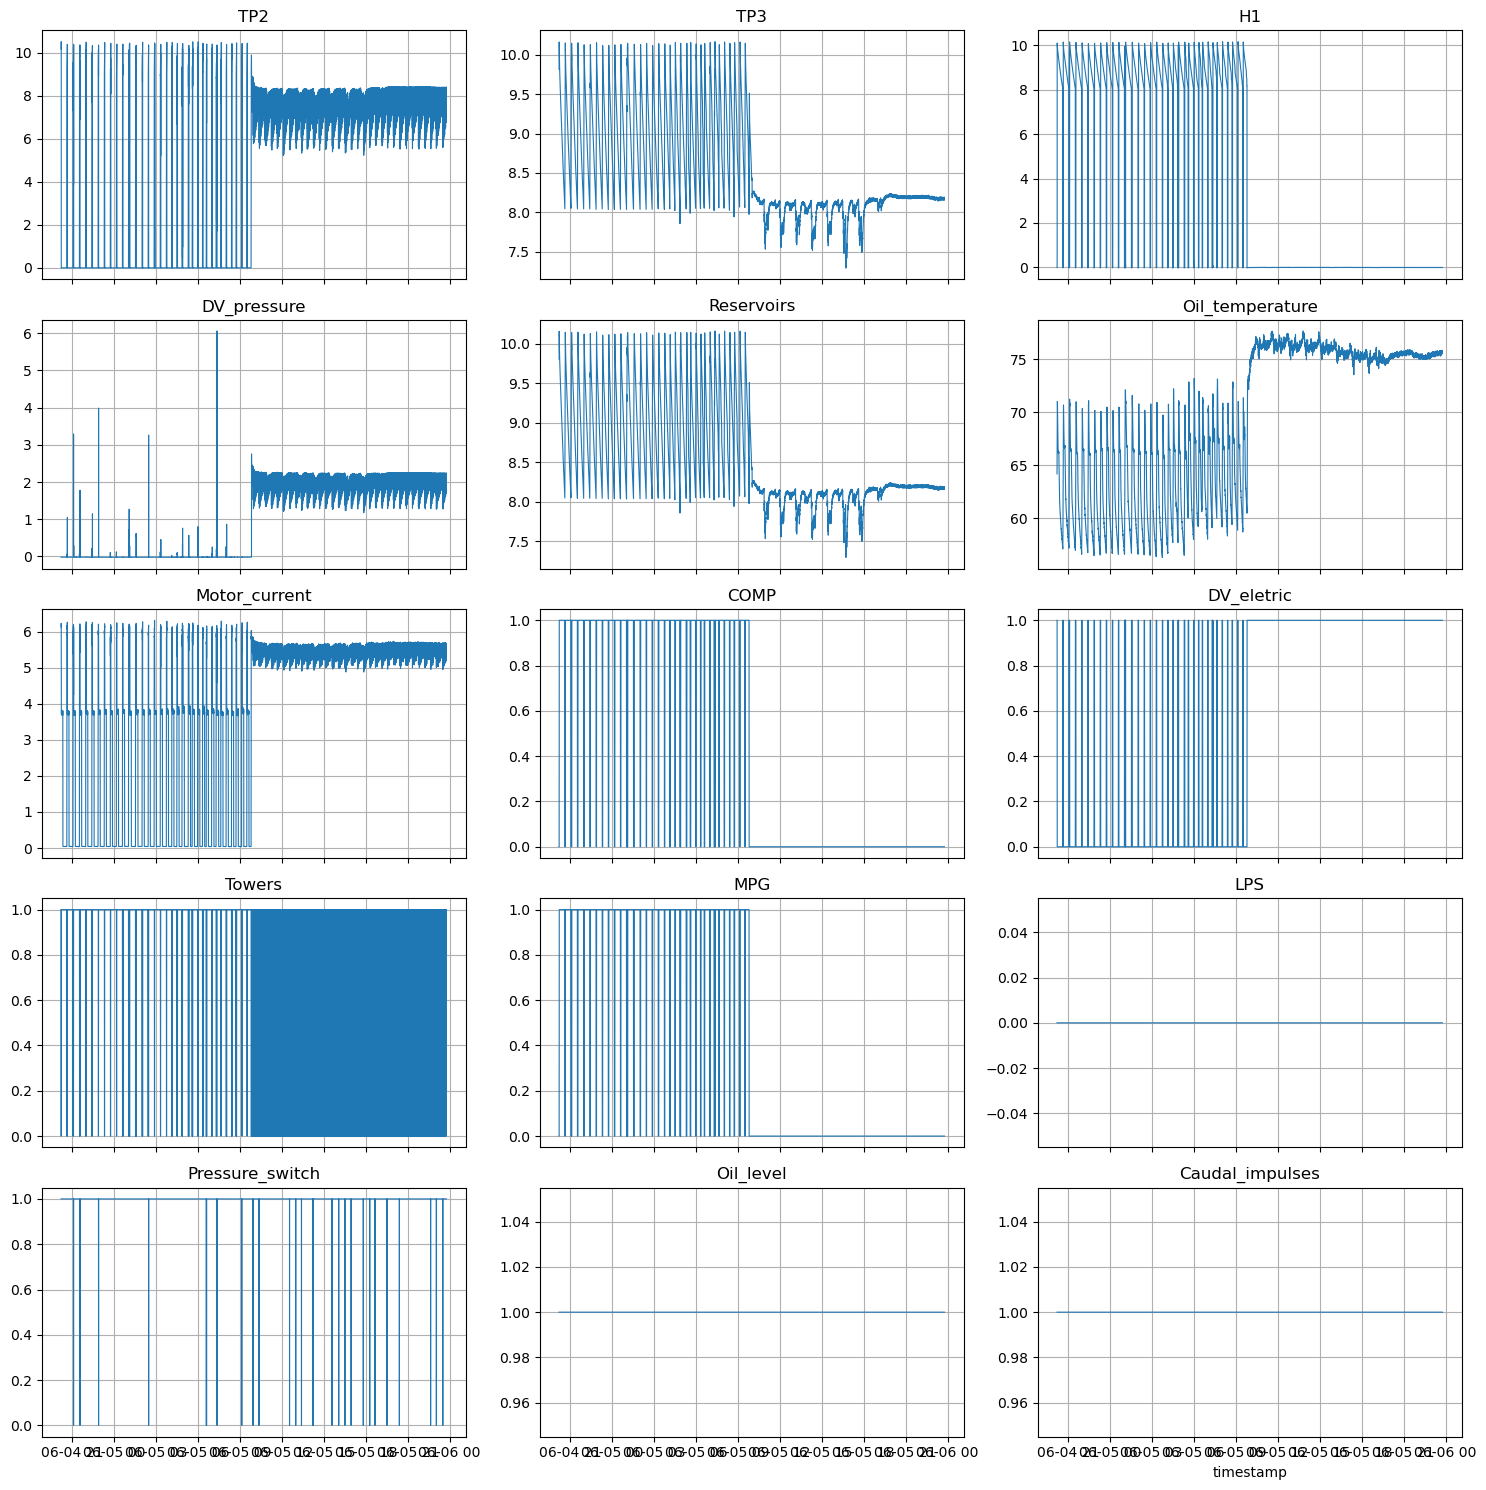

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# On extrait 1000 lignes autour de la première erreur : "2020-04-18 00:00:00"

# On s'assure que la colonne timestamp est sous le format datetime pour faciliter les opérations
if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
    df['timestamp'] = pd.to_datetime(df['timestamp'])

target = pd.to_datetime("6/5/2020 10:00")

# On trouve l'index de la ligne la plus proche notre cible
closest_idx = (df['timestamp'] - target).abs().idxmin()
pos = df.index.get_loc(closest_idx)

n = 10000
half = n // 2
start = max(0, pos - half)
end = start + n
if end > len(df):
    end = len(df)
    start = max(0, end - n)

# On a alors un nouveau dataframe avec les 1000 lignes autour de la panne
df_around_failure = df.iloc[start:end].copy()


# On sélectionne les variables numériques à tracer (en excluant la première colonne servant d'index)
num_cols = df_around_failure.select_dtypes(include='number').columns.tolist()
if 'Unnamed: 0' in num_cols:
    num_cols.remove('Unnamed: 0')

n = len(num_cols)
cols = 3
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows), sharex=True)
axes = axes.flatten()

for i, col in enumerate(num_cols):
    axes[i].plot(df_around_failure['timestamp'], df_around_failure[col], lw=0.8)
    axes[i].set_title(col)
    axes[i].grid(True)


for j in range(n, len(axes)):
    axes[j].axis('off') # On désactive les axes inutilisés

plt.xlabel('timestamp')
plt.tight_layout()
plt.show()

On distingue bien sur toutes les premières courbes (TP1? TP2, H1, DV_pressure, Reservoirs, Oil_temperature, Motor_current, COMP, DV_electric, Towers, MPG) une variation anormale des signaux pendant la période d'erreur. Ces variables semblent donc pertinentes pour la détection d'anomalies.

On visualise quand même les variables sur toute la période de mesure même si on s'attend à des courbes surchargées du fait du nombre important de points.

⚠️⚠️⚠️⚠️⚠️⚠️ moi ça crash mon kernel quand je lance ça donc à voir si on garde ou pas ⚠️⚠️⚠️⚠️⚠️⚠️

In [17]:
num_cols = df.select_dtypes(include='number').columns.tolist()
if 'Unnamed: 0' in num_cols:
    num_cols.remove('Unnamed: 0')

n = len(num_cols)
cols = 3
rows = int(np.ceil(n / cols))

fig_full, axes_full = plt.subplots(rows, cols, figsize=(15, 3 * rows), sharex=True)
axes_full = axes_full.flatten()

for i, col in enumerate(num_cols):
    axes_full[i].plot(df['timestamp'], df[col], lw=0.6)
    axes_full[i].set_title(col)
    axes_full[i].grid(True)

for j in range(n, len(axes_full)):
    axes_full[j].axis('off')

plt.xlabel('timestamp')
plt.tight_layout()
plt.show()

: 

Pour le moment nos données ne sont pas labellisées. Mais comme les périodes d'erreurs sont connues, on peut s'en servir pour labelliser les données. On va donc créer une nouvelle colonne "failure" qui prendra la valeur 1 pendant les périodes d'erreurs et 0 sinon. Ainsi nos données seront labellisées et on pourra entraîner un modèle de classification supervisée pour détecter les anomalies.

In [5]:
df['failure'] = 0

# Erreur 1
failure_start = pd.to_datetime("4/18/2020 0:00")
failure_end = pd.to_datetime("4/18/2020 23:59")
df.loc[(df['timestamp'] >= failure_start) & (df['timestamp'] <= failure_end), 'failure'] = 1

# Erreur 2
failure_start = pd.to_datetime("5/29/2020 23:30")
failure_end = pd.to_datetime("5/30/2020 6:00")
df.loc[(df['timestamp'] >= failure_start) & (df['timestamp'] <= failure_end), 'failure'] = 1

# Erreur 3
failure_start = pd.to_datetime("6/5/2020 10:00")
failure_end = pd.to_datetime("6/7/2020 14:30")
df.loc[(df['timestamp'] >= failure_start) & (df['timestamp'] <= failure_end), 'failure'] = 1

# Erreur 4
failure_start = pd.to_datetime("7/15/2020 14:30")
failure_end = pd.to_datetime("7/15/2020 19:00")
df.loc[(df['timestamp'] >= failure_start) & (df['timestamp'] <= failure_end), 'failure'] = 1


On a décidé de séparer notre set de données et un jeu d'entraînement et un jeu de test. La partie Train permet d'entraîner le modèle de détection d'anomalies sur une partie des données et la partie Test permet d'évaluer les performances du modèle sur des données qu'il n'a jamais vues auparavant.

Cette séparation permet de vérifier si le modèle est capable de généraliser ses prédictions à de nouvelles données et d'éviter le surapprentissage sur les données d'entraînement.

On utilise une séparation aléatoire avec 70% des données pour l'entraînement et 30% pour le test. On utilise l'option stratify pour s'assurer que la proportion d'erreurs est conservée dans les deux ensembles.

In [6]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, shuffle=True, stratify=df['failure'])

On teste ensuite plusieurs modèles d'apprentissage sur nos données. 

## Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier
from tqdm.auto import tqdm
from sklearn.metrics import classification_report

features = train_df.select_dtypes(include='number').drop(columns=['failure', 'Unnamed: 0']).columns
X_train = train_df[features]
y_train = train_df['failure']

n_estimators = 100
# On utilise warm_start pour faire grandir la forêt progressivement et afficher la progression
model = RandomForestClassifier(n_estimators=1, random_state=42, warm_start=True, n_jobs=-1)

with tqdm(total=n_estimators, desc="Training RandomForest", unit="est") as pbar:
    for i in range(n_estimators):
        model.n_estimators = i + 1
        model.fit(X_train, y_train)
        pbar.update(1)

# On évalue le modèle 
X_test = test_df[features]
y_test = test_df['failure']
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

Training RandomForest:   0%|          | 0/100 [00:00<?, ?est/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    446099
           1       0.98      0.99      0.98      8986

    accuracy                           1.00    455085
   macro avg       0.99      0.99      0.99    455085
weighted avg       1.00      1.00      1.00    455085



La précision nous donne la proportion de prédictions positives correctes parmi l'ensemble des prédictions effectuées par le modèle. Une précision de 0.98 indique qu'il y a peu de faux positifs, c'est-à-dire que le modèle identifie correctement la plupart des anomalies détectées.

Le rappel donne la proportion de véritables anomalies qui ont été correctement identifiées par le modèle. Un rappel de 0.99 indique que le modèle détecte la majorité des anomalies réelles, avec peu de faux négatifs.

Le F1-score est la moyenne jarmonique entre la précision et le rappel. Un F1-score de 0.98 suggère que le modèle maintient un bon équilibre entre la précision et le rappel, ce qui est crucial dans les tâches de détection d'anomalies où les deux métriques sont importantes.

Ainsi, le modèle Random Forest montre d'excellentes performances dans la détection des anomalies sur les données de test, avec des scores élevés pour la précision, le rappel et le F1-score. Il distingue efficacement les anomalies des données normales.

## Logistic Regression 

In [8]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    446099
           1       0.75      0.80      0.77      8986

    accuracy                           0.99    455085
   macro avg       0.87      0.90      0.89    455085
weighted avg       0.99      0.99      0.99    455085



75% des prédictions positives sont correctes, ce qui indique que le modèle fait un certain nombre de faux positifs.

Avec un f1-score de 0.77, le modèle de régression logistique montre des performances modérées dans la détection des anomalies. Il y a un équilibre raisonnable entre la précision et le rappel, mais il y a encore place à l'amélioration. Ce modèle est moins performant que le modèle Random Forest précédent. 

Comme la régression logistique est un modèle linéaire, il peut avoir des difficultés à capturer des relations complexes dans les données. Dans notre étude de données sur la rame de métro, les anomalies peuvent être expliquées par des relations complexes et non linéaires entre les différentes variables mesurées par les capteurs. Par conséquent, un modèle plus sophistiqué comme Random Forest, qui peut capturer ces relations complexes avec la combinaison de plusieurs arbres de décisions, est plus adapté pour cette tâche.

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)
y_pred_nb = model_nb.predict(X_test)
print(classification_report(y_test, y_pred_nb))


              precision    recall  f1-score   support

           0       1.00      0.91      0.95    446099
           1       0.18      0.99      0.30      8986

    accuracy                           0.91    455085
   macro avg       0.59      0.95      0.63    455085
weighted avg       0.98      0.91      0.94    455085



Sur ce modèle, seulement 18% des prédictions positives sont correctes, ce qui indique que le modèle fait de nombreux faux positifs. Ainsi, même si le rapel est très élevé, le f1-score est faible et l'équilibre entre précision et rappel n'est pas bon. Le modèle détecte presque toutes les anomalies mais il alerte aussi beaucoup sur de fausses anomalies. 

Le modèle Naive Bayes semble ainsi moins adapté pour cette tâche de détection d'anomalies dans les données de la rame de métro. En effet, ce modèle suppose que toutes les varibles sont indépendantes les unes des autres (hypothèse d'indépendance conditionnelle), ce qui n'est sûrement pas le cas dans notre jeu de données où les différentes mesures des capteurs sont corrélées et liées entre elles. L'hypothèse utilisé par le modèle est alors fausse et il est icapable de bien séparer les anomalies des données normales. Un modèle plus complexe comme Random Forest ou XGBoost, qui peut capturer ces dépendances entre les variables, est alors plus approprié pour pour notre étude.

## XGBoost 

In [ ]:
import xgboost as xgb
model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:06:48] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    446099
           1       0.97      0.97      0.97      8986

    accuracy                           1.00    455085
   macro avg       0.98      0.98      0.98    455085
weighted avg       1.00      1.00      1.00    455085



En effet, le modèle XGBoost montre d'excellentes performances dans la détection des anomalies sur les données de test, avec des scores élevés pour la précision, le rappel et le F1-score. Il distingue quasi-parfaitement les anomalies des données normales, comme le modèle Random Forest vu précédemment.

Le modèle XGBoost est particulièrement adapté pour cette tâche de détection d'anomalies dans les données de la rame de métro. En effet, XGBoost est un algorithme de boosting qui combine plusieurs modèles faibles (arbres de décision) pour créer un modèle plus robuste et performant. Il est capable de gérer des relations complexes entre les variables et les interactions non linéaires, ce qui est nécessaire dans notre jeu de données où les mesures des capteurs sont souvent corrélées. Il est aussirobuste face aux bruits et aux données hétérogènes, qui peuvent être présents dans des données collectées à partir d'une rame de métro en service. 

## Bagging Classifier

In [ ]:
from sklearn.ensemble import BaggingClassifier
model_bag = BaggingClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model_bag.fit(X_train, y_train)
y_pred_bag = model_bag.predict(X_test)
print(classification_report(y_test, y_pred_bag))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    446099
           1       0.98      0.98      0.98      8986

    accuracy                           1.00    455085
   macro avg       0.99      0.99      0.99    455085
weighted avg       1.00      1.00      1.00    455085



Cette méthode donne aussi d'excellent score de précision, de rappel et de f1-score. Le Bagging Classifier combine plusieurs modèles (comme des arbres de décision) entraînés sur des sous-ensembles différents. Il réduit alors la variance et le risque de surapprentissage. Il capture bien les relations complexes entre les variables comme le modèle Random Forest. Il est aussi assez robuste face aux bruits et aux données hétérogènes. 

## SVM

In [ ]:
from sklearn.svm import SVC
model_svm = SVC(random_state=42)
model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_test)
print(classification_report(y_test, y_pred_svm))

Les SVM classiques ne sont pas très adaptés pour la détection d'anomalies sur un jeu de donées volumineux comme celui que nous traitons. Comme il calcule et stocke une matrice de similarité entre tous les points, l'algorithme est très lent. 

## Conclusion

**Random Forest**, **XGBoost** et **Bagging Classifier** sont les méthodes les plus adaptées à la détection d'anomalies dans des données issues de capteurs installées sur une rame de métro. Pour l'anomalie étudiée (Air Leak), ces modèles détectent à plus de 97% les erreurs dans un jeu de données et sans détecter de fausses erreurs non plus. 

Ces modèles utilisées sur des données issues en direct de notre rame de métro pourraient permettre de détecter efficacement des anomalies et ainsi d'alerter les équipes de maintenance avant qu'une panne ne survienne ou au moment de la panne. Cela permettrait d'améliorer la fiabilité et la sécurité du métro tout en réduisant les coûts de maintenance imprévus et les délais de réparation.